# MCMC parameter inference using backward filtering, forward guiding

A question we left in the last notebook is to infer the unknown parameter `sigma` in the LDDMM model. Generally, parameter inference on the tree is one of the crucial tasks in phylogenetics, which is usually done by Markov chain Monte Carlo (MCMC). However, the execution of MCMC requires to run the updates across the whole tree for many times, which can be extremely time costly if the operation is not well optimized. With the help of _Hyperiax_, you will no longer need to spend energy on how to optimize your operation for the entire tree, instead, just need to consider a single children-parent pair. This will enable you to concentrate on the required operation itself, and _Hyperiax_ will take care of the rest.

In this notebook, we will show how to do parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes. The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this examples.

**Content of the notebook**

* Sample the tree downwards with Gaussian transitions and node-dependent covariances

* Estimate the tree upwards conditioning on the leaf observations

* Infer the variance of leaf nodes using MCMC

In [1]:
from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree
from hyperiax.models import UpLambdaReducer, DownLambda
from hyperiax.execution import OrderedExecutor
from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter

import jax
from jax import numpy as jnp
from jax.random import PRNGKey, split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
key = PRNGKey(42)
jnp.set_printoptions(precision=3)

## Build a Gaussian tree with constant node-dependent covariances

**Simulate the tree downwards with unconditional transition**

As usual, we first build a tree as our study case. We shall use a symmetric tree with `height=2` and `degree=10`, and the data stored in nodes is vectors in $\mathbb{R}^2$, with the root initialized as $(0, 0)$.

In [3]:
# create topology and tree
topology = symmetric_topology(height=2, degree=10)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(d,))
tree.add_property('noise', shape=(d,))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
root = jnp.zeros(d)
tree.data['value'] = tree.data['value'].at[0].set(root)

                                                                                                                                                                                                                                                       None
                       ┌─────────────────────────────────────────────────┬─────────────────────────────────────────────────┬─────────────────────────────────────────────────┬─────────────────────────────────────────────────┬────────────────────────┴────────────────────────┬─────────────────────────────────────────────────┬─────────────────────────────────────────────────┬─────────────────────────────────────────────────┬─────────────────────────────────────────────────┐
                      None                                              None                                              None                                              None                                              None                                              N

We then define parameters for the tree. All the parameters of the tree should be packed into `ParameterStore()` in `dict`. Here we define two parameters: `variance` $\sigma$ and `obs_var` $\sigma_{obs}$: $\sigma$ determines the variance of the Gaussian transition kernel within the unit edge length, since we model the dynamics from the parent to children as Gaussian, that is, if we denote the parent and child as $p$ and $c$ individually, then $c\sim\mathcal{N}(p, \sigma\cdot l\cdot\mathbf{I})$, and $l$ is the edge length between $c$ and $p$; $\sigma_{obs}$, however, specify the variance of the `noise` store in each node. The final value of $c$ is integrated by these two random distributions.

In [4]:
# parameters, variance and observation noise
params = ParameterStore({
    'variance': VarianceParameter(.5), # variance of the Gaussian transition kernel 
    'obs_var':  VarianceParameter(.01) # observation noise variance
})

Now follows the down transitions. At first, we define the unconditional transitions, which are just **Gaussian** samples, and implemented as `down_unconditional`. The covariance is the identity in $\mathbb{R}^d$ times the variance parameter $\sigma$ times edge lengths $l$, then the `noise` exists in the node is counted afterwards.

In [5]:
# batched version of down_unconditional. The b index refers to the batch, the first axis of W. Alternatively, jax.vmap can be used to vectorize the function, see the down_conditional function below as an example
@jax.jit
def down_unconditional(noise, edge_length, parent_value, params, **args):
    var = params['variance'] * edge_length # total edge variance
    return {'value': parent_value + jnp.einsum('b,ij,bj->bi', jnp.sqrt(var), jnp.eye(d), noise)}

downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. **Note that observation `noise` is not added to the leaves yet**. We need to pass the set parameter `param` into the executor as the additional argument by `params.values()`.

In [6]:
# sample new noise, used to compute the sampling by the Gaussian transitions.
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree, subkey)
down_unconditional.down(tree, params.values())

Now we add observation noise to leaves, and we can use `tree.is_leaf` to identify the leaves.

In [7]:
key, subkey = split(key)
leaf_values = tree.data['value'][tree.is_leaf] \
    + jnp.sqrt(params['obs_var'].value) * jax.random.normal(subkey, tree.data['value'][tree.is_leaf].shape)
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)

Text(0.5, 1.0, 'Sampled tree with leaf noise')

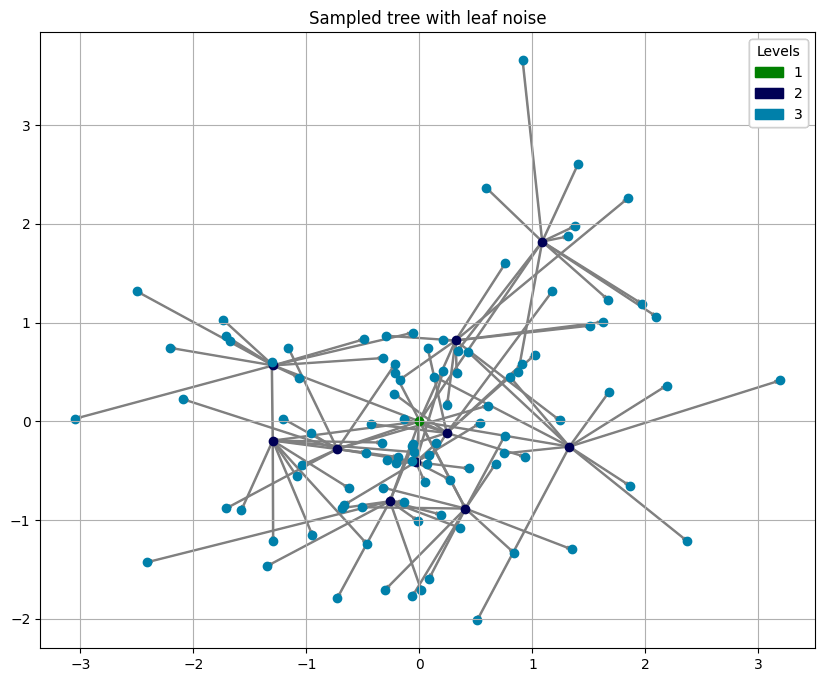

In [8]:
# plot the generated tree
plot_tree_2d_scatter(tree, 'value')
plt.gca().set_title('Sampled tree with leaf noise')

**Estimate inner nodes conditioning on the observations of leaves**

We now define the backwards filter through the `up` function. By executing `up` function layer by layer from the bottom leaves to the top root, the information of leaves (in this case, the parameters of the distribution that leaves follow) has been passed along the tree up to the root. The Gaussian are parametrized in the $(c,F,H)$ format make the `fuse` just a sum of the results of the `up` operation, and the information carried is $(F, H)$. See https://arxiv.org/abs/2203.04155 for details.

In [9]:
# backwards filter
@jax.jit
def up(noise, edge_length, F_T, H_T, params, **args):
    
    def f(noise, edge_length, F_T, H_T):
        T = edge_length # edge length, we here used T using the analogy to the continuous case where T denotes the evaluation time of a Brownian motion
        var = T * params['variance'] # total edge variance
        covar = var * jnp.eye(d) # covariance matrix

        Sigma_T = jnp.linalg.inv(H_T)
        v_T = Sigma_T @ F_T
    
        invPhi_0 = (jnp.eye(d) + H_T * covar)
        Sigma_0 = Sigma_T @ invPhi_0 # = Sigma_T+covar
        H_0 = jnp.linalg.inv(Sigma_0)
        F_0 = jnp.linalg.solve(invPhi_0, F_T)
        #v_0 = Sigma_0@F_0
        #c_0 = -jnp.real(jax.scipy.stats.multivariate_normal.logpdf(v_0,jnp.zeros(d),Sigma_0))
    
        return {'F_0': F_0, 'H_0': H_0}
    
    return jax.vmap(f)(noise, edge_length, F_T, H_T)

def transform(child_F_0, child_H_0, **args):
    return {'F_T': child_F_0, 
            'H_T': child_H_0}

upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

We initialize the tree for up by computing the $(c,F,H)$-values at the leaves.

In [10]:
# initialize tree for up
tree.add_property('F_0', shape=(d,))
tree.add_property('H_0', shape=(d, d)) 
tree.add_property('F_T', shape=(d,))
tree.add_property('H_T', shape=(d, d))

def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(d) / params['obs_var'].value)[None, :, :])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jnp.einsum('bij,bj->bi', tree.data['H_T'][tree.is_leaf], leaf_values))
    # Sigma = params['obs_var'].value * jnp.eye(d)
    #tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(-jax.vmap(lambda v: jnp.real(jax.scipy.stats.multivariate_normal.logpdf(v,jnp.zeros(d),Sigma)))(leaf_values))

Suppose the information from the leaves has been passed to the root by `up`, we can now define the conditional downwards pass `down_conditional`, i.e. the forwards guiding, that runs downwards again. 

In [11]:
@jax.jit
def down_conditional(noise, edge_length, F_T, H_T, parent_value, params, **args):
    
    def f(noise, edge_length, F_T, H_T, parent_value):
        T = edge_length # edge length 
        x = parent_value
        var = T*params['variance'] # total edge variance
        covar = var * jnp.eye(d) # covariance matrix

        invSigma = jnp.linalg.inv(covar)
        H = H_T + invSigma
        mu = jnp.linalg.solve(H, F_T + invSigma @ x)
        return {'value': mu + jnp.linalg.solve(jnp.real(jax.scipy.linalg.sqrtm(H)), noise)}

    return jax.vmap(f)(noise, edge_length, F_T, H_T, parent_value)

downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (unconditional down, conditional down, and up).

In [12]:
# backwards filter and forwards guiding
init_up(leaf_values, params)
up.up(tree, params.values()) # backwards filter
down_conditional.down(tree, params.values()) # forwards guiding

# time the operations
subkey, key = split(key)
update_noise(tree, subkey)
down_unconditional.down(tree, params.values())
%time down_unconditional.down(tree, params.values())
%time down_conditional.down(tree, params.values())
%time up.up(tree, params.values())

CPU times: user 38 μs, sys: 1 μs, total: 39 μs
Wall time: 42.2 μs
CPU times: user 305 μs, sys: 77 μs, total: 382 μs
Wall time: 219 μs
CPU times: user 75 μs, sys: 23 μs, total: 98 μs
Wall time: 100 μs


We test the setup by sampling a number of trees and computing mean and covariance of the leaf data.

In [13]:
# do statistics on the leaf values
F = tree.data['F_T'][0]; H = tree.data['H_T'][0]
print("Mean:")
print(f"root conditional mean vs. sample mean: \n {jnp.linalg.solve(H,F)} \n {jnp.mean(leaf_values,0)}")
print("Covariance:")
print(f"root conditional cov. vs. sample cov: \n {jnp.linalg.inv(H)} \n {jnp.cov(leaf_values.T)}")

Mean:
root conditional mean vs. sample mean: 
 [0.042 0.038] 
 [0.042 0.038]
Covariance:
root conditional cov. vs. sample cov: 
 [[0.055 0.   ]
 [0.    0.055]] 
 [[1.296 0.301]
 [0.301 1.081]]


In [14]:
# sample statistics
K = 500 # number samples
samples = jnp.zeros((K, sum(tree.is_leaf), d))
samples_noise = jnp.zeros((K, sum(tree.is_leaf), d))
samples_conditional = jnp.zeros((K, sum(tree.is_leaf), d))

for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(tree, subkey)
    down_unconditional.down(tree, params.values())
    values = tree.data['value'][tree.is_leaf]
    # collect values
    samples = samples.at[i].set(values)
    # add observation noise
    subkey,key = split(key)
    samples_noise = samples_noise.at[i].set(values + jnp.sqrt(params['obs_var'].value) * jax.random.normal(subkey, values.shape))
    # conditional sampling
    update_noise(tree, subkey)
    down_conditional.down(tree, params.values())
    samples_conditional = samples_conditional.at[i].set(tree.data['value'][tree.is_leaf])
    
# print sample statistics for first 10 leaves
print("First 10 leaves: ")
for i in range(10):
    print(f"Leaf {i}:")
    print("mean:\n", jnp.mean(samples[:,i],0))
    print("cov:\n", jnp.cov(samples[:,i].T))
    print("mean conditional:\n ",jnp.mean(samples_conditional[:,i],0))
    print("sample:\n", leaf_values[i])
    print("cov conditional:\n",jnp.cov(samples_conditional[:,i].T))
    print("mean w/ noise:\n",jnp.mean(samples_noise[:,i],0))
    print("cov w/ noise:\n",jnp.cov(samples_noise[:,i].T))
    print("--"*20)

100%|██████████| 500/500 [00:00<00:00, 834.00it/s]


First 10 leaves: 
Leaf 0:
mean:
 [-0.039  0.041]
cov:
 [[ 0.971 -0.032]
 [-0.032  1.124]]
mean conditional:
  [ 0.003 -1.705]
sample:
 [ 0.017 -1.714]
cov conditional:
 [[ 0.009 -0.   ]
 [-0.     0.01 ]]
mean w/ noise:
 [-0.035  0.038]
cov w/ noise:
 [[ 0.975 -0.033]
 [-0.033  1.138]]
----------------------------------------
Leaf 1:
mean:
 [-0.008  0.05 ]
cov:
 [[1.003 0.075]
 [0.075 1.072]]
mean conditional:
  [-2.367 -1.418]
sample:
 [-2.411 -1.428]
cov conditional:
 [[ 0.009 -0.   ]
 [-0.     0.01 ]]
mean w/ noise:
 [-0.007  0.048]
cov w/ noise:
 [[1.009 0.074]
 [0.074 1.087]]
----------------------------------------
Leaf 2:
mean:
 [-0.043  0.007]
cov:
 [[0.939 0.014]
 [0.014 0.959]]
mean conditional:
  [-0.143 -0.818]
sample:
 [-0.137 -0.817]
cov conditional:
 [[ 0.01  -0.   ]
 [-0.     0.011]]
mean w/ noise:
 [-0.045  0.004]
cov w/ noise:
 [[0.943 0.011]
 [0.011 0.967]]
----------------------------------------
Leaf 3:
mean:
 [-0.004  0.086]
cov:
 [[ 0.993 -0.081]
 [-0.081  1.056]]

## Estimate variance using MCMC

We make two MCMC runs: 

* We use that the model with constant node covariance is fully Gaussian and we can read the data likelihood directly from the results of upwards pass.

* We also sample the state of the tree to get a likelihood approximation from the conditional downwards pass. (This version is not necessary in the current model, but it points towards how inference in non-Gaussian models (e.g. non-linear diffusion processes along the edges) will look.)

Initial parameters:  {'variance': 0.25, 'obs_var': 0.01}
data parameters:  {'variance': 0.5, 'obs_var': 0.01}


100%|██████████| 1200/1200 [00:02<00:00, 411.54it/s]

Acceptance rate: 0.9358


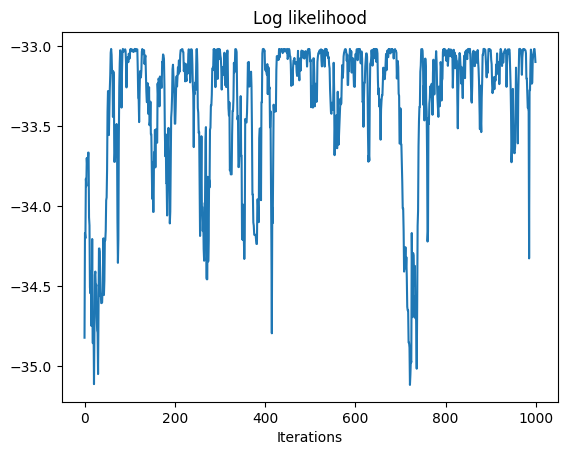

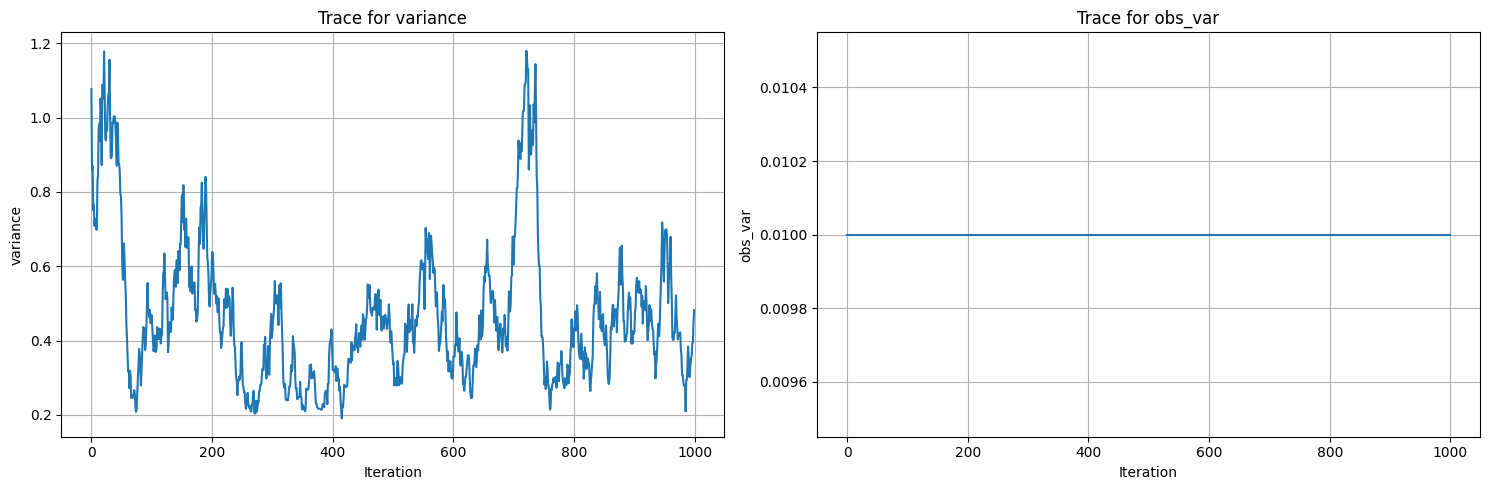

In [15]:
# inference for Gaussian model, likelihood from backwards filtering
def log_likelihood(data, state):
    """Log likelihood of the tree."""
    params, = state
    init_up(data, params) 
    up.up(tree, params.values())
    v, F, H = tree.data['value'][0], tree.data['F_T'][0], tree.data['H_T'][0]
    c = -jnp.real(jax.scipy.stats.multivariate_normal.logpdf(v, jnp.zeros(d), jnp.linalg.inv(H)))
    return -c + F @ v - 0.5 * v.T @ H @ v

def log_posterior(data, state):
    """Log posterior given the state and data."""
    params, = state
    log_prior = params.log_prior()
    log_like = log_likelihood(data, state)
    return log_prior + log_like

def proposal(state, key):
    params, = state
    new_params = params.propose(key)
    return (new_params, )

# tree values and parameters
init_params = ParameterStore({
    'variance': VarianceParameter(.25), # variance of the Gaussian transition kernel 
    'obs_var': VarianceParameter(.01, alpha=3, beta=.5, keep_constant=True) # observation noise variance. We keep it constant here because of lacking identifiability (which will not be the case with higher-dimensional correlated data)
    })
print("Initial parameters: ", init_params.values())
print("data parameters: ", params.values())

# initial state
init_up(leaf_values, init_params)
init_state = (init_params, )

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 1000, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)

Initial parameters:  {'variance': 0.25, 'obs_var': 0.01}
data parameters:  {'variance': 0.5, 'obs_var': 0.01}


100%|██████████| 1200/1200 [00:03<00:00, 360.65it/s]


Acceptance rate: 0.3292


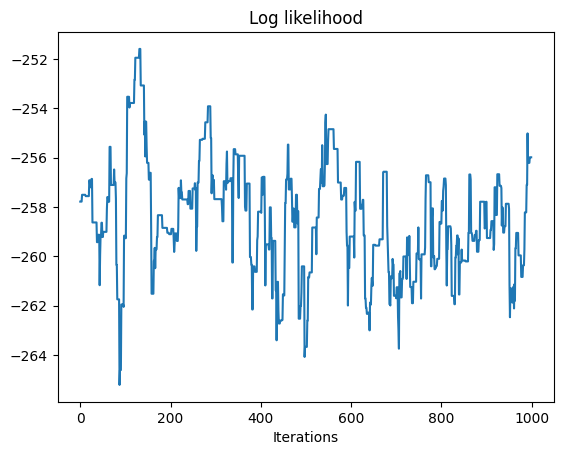

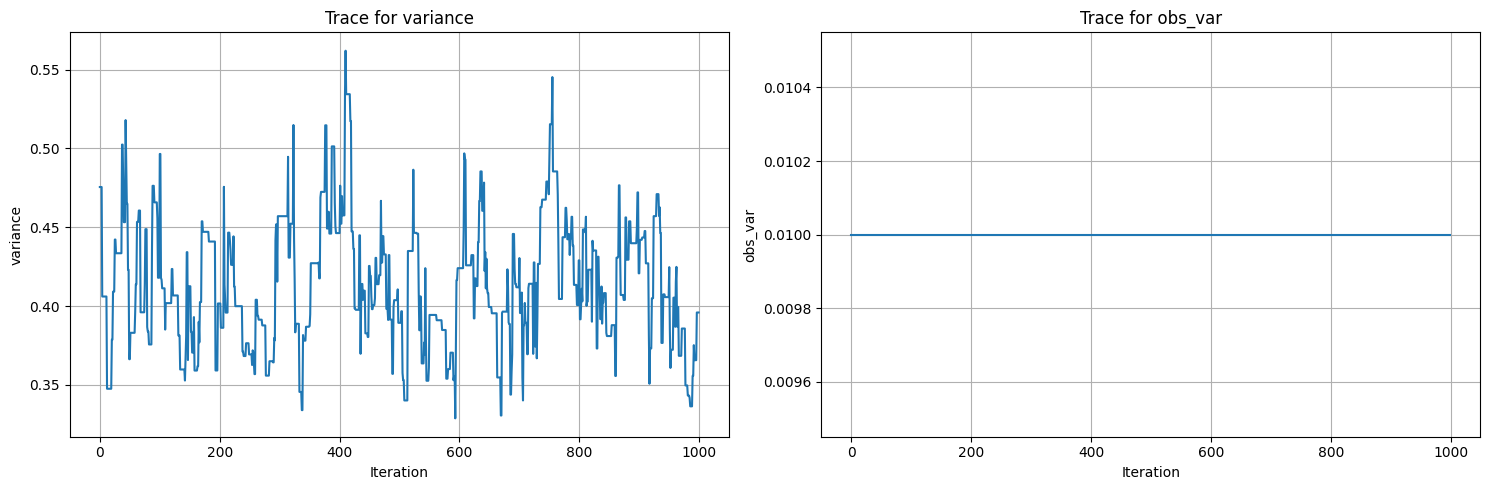

In [16]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise * lambd + jnp.sqrt((1 - lambd**2)) * jax.random.normal(key, noise.shape)

# downwards pass to compute likelihoods
tree.add_property('log_likelihood', shape=())

@jax.jit
def down_log_likelihood(value, edge_length, parent_value, params, **args):
    var = params['variance'] * edge_length # total edge variance
    covar = jnp.einsum('b,ij->bij', var, jnp.eye(d)) # covariance matrix

    return {'log_likelihood': jax.vmap(lambda value, m, covar: jnp.real(jax.scipy.stats.multivariate_normal.logpdf(value,m,covar)))(value, parent_value, covar)}

downmodel_log_likelihood = DownLambda(down_fn=down_log_likelihood)
down_log_likelihood = OrderedExecutor(downmodel_log_likelihood)

# log likelihood of the tree
def log_likelihood(data, state):
    """Log likelihood of the tree."""
    params,noise = state
    init_up(data, params)
    up.up(tree,params.values())
    tree.data['noise'] = noise 
    down_conditional.down(tree, params.values())
    down_log_likelihood.down(tree, params.values())
    return jnp.sum(tree.data['log_likelihood'][1:]) # ignore root node

def log_posterior(data, state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data, state)
    return log_prior + log_like

def proposal(state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters, new_noise

# tree values and parameters
init_params = ParameterStore({
    'variance': VarianceParameter(.25), # variance of the Gaussian transition kernel 
    'obs_var': VarianceParameter(.01, alpha=3, beta=.5, keep_constant=True) # observation noise variance
    })
print("Initial parameters: ", init_params.values())
print("data parameters: ", params.values())

# initial state
init_up(leaf_values, init_params)
init_state = (init_params, jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 1000, burn_in=200, rng_key=key, savef = lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)